## Task: Train an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.

You are provided with the code to load the EMNIST train and split **datasets**

Write and train a classifier for EMNIST. Make sure to

- Show how your loss(es) dropped during training.
- Show final performance of your model on untrained data.
- Maintain good code quality.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

In [2]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False)

100%|██████████| 561753746/561753746 [00:22<00:00, 25392868.59it/s]


Extracting emnist_data/EMNIST/raw/gzip.zip to emnist_data/EMNIST/raw


In [155]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
torchvision.transforms.functional.resize(demo_img, (255, 255))

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [156]:
# Transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the datasets
train_data = EMNIST(root='emnist_data/', split='byclass', train=True, download=True, transform=transform)
test_data = EMNIST(root='emnist_data/', split='byclass', train=False, download=True, transform=transform)

# Define the size of the subset as a fraction of the original dataset
subset_fraction = 0.1 ## You can play with this to get a bigger or smaller subset

# Create indices for the training subset
train_indices = np.random.choice(len(train_data), int(len(train_data) * subset_fraction), replace=False)

# Create the training subset
train_subset = Subset(train_data, train_indices)

# For the test set, you can do the same or use the full test set
test_indices = np.random.choice(len(test_data), int(len(test_data) * subset_fraction), replace=False)
test_subset = Subset(test_data, test_indices)

# Check the size of the subset
print(f"Training subset size: {len(train_subset)}")
print(f"Test subset size: {len(test_subset)}")

# Define the DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Training subset size: 69793
Test subset size: 11632


In [157]:
print("The image shape:", demo_img)

The image shape: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000

In [158]:
class EMNISTClassifier(nn.Module):
  def __init__(self, input_size):
    super(EMNISTClassifier, self).__init__()
    self.layer_1 = nn.Linear(input_size, 256)
    self.layer_2 = nn.Linear(256, 128)
    self.layer_3 = nn.Linear(128, 62)

    self.relu = nn.LeakyReLU()

  def forward(self, x):
    x = self.relu(self.layer_1(x))
    x = self.relu(self.layer_2(x))
    x = self.layer_3(x)
    return x



In [159]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

Using device cuda


In [160]:
input_size = 28 * 28
model = EMNISTClassifier(input_size).to(device)

In [161]:

num_epochs = 16
lr = 1e-4

train_losses = []
val_losses = []


optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [162]:
%%time
for epoch in range(num_epochs):

  model.train()
  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.view(-1, 28 * 28)

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    batch_y_hat = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_hat, batch_y)

    # Reset
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += len(batch_y) * loss.item()

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  train_losses.append(epoch_loss)

  print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss}')




  # validation

  model.eval()
  correctly_labelled = 0

  with torch.no_grad():

    test_epoch_weighted_loss = 0

    for test_batch_X, test_batch_y in test_loader:

        test_batch_X = test_batch_X.view(-1, 28 * 28)

        test_batch_X = test_batch_X.to(device)
        test_batch_y = test_batch_y.to(device)

        val_batch_y_probs = model(test_batch_X)

        loss = criterion(val_batch_y_probs, test_batch_y)

        test_epoch_weighted_loss += len(test_batch_y) * loss.item()

        # convert probailities to labels by picking the label (index) with the highest prob.
        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

        correctly_labelled += (val_batch_y_pred == test_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = test_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')


Epoch [1/16], Train Loss: 1.86941798577703
Labelled 7526/11632 correctly (64.70082530949107% accuracy)
Epoch [2/16], Train Loss: 1.1803687757931483
Labelled 7970/11632 correctly (68.51788170563961% accuracy)
Epoch [3/16], Train Loss: 1.0379167088436705
Labelled 8326/11632 correctly (71.57840440165062% accuracy)
Epoch [4/16], Train Loss: 0.9398480360224402
Labelled 8569/11632 correctly (73.66746905089408% accuracy)
Epoch [5/16], Train Loss: 0.8679990442880047
Labelled 8702/11632 correctly (74.81086657496562% accuracy)
Epoch [6/16], Train Loss: 0.8132861944008974
Labelled 8833/11632 correctly (75.93707015130674% accuracy)
Epoch [7/16], Train Loss: 0.7698752861351755
Labelled 8911/11632 correctly (76.6076341127923% accuracy)
Epoch [8/16], Train Loss: 0.7327174501676094
Labelled 8899/11632 correctly (76.5044704264099% accuracy)
Epoch [9/16], Train Loss: 0.7008294995335119
Labelled 9057/11632 correctly (77.86279229711141% accuracy)
Epoch [10/16], Train Loss: 0.6734287282266371
Labelled 9044

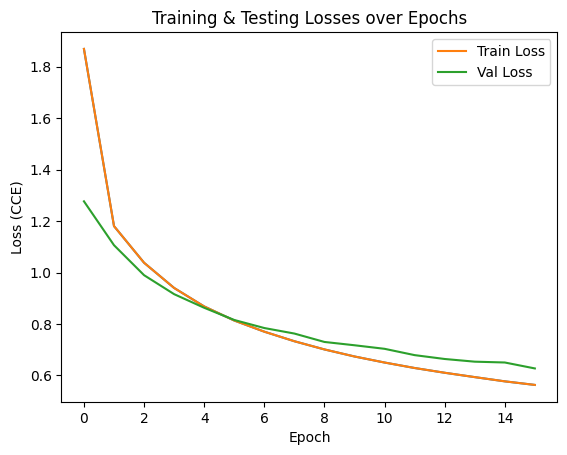

In [164]:
plt.plot(train_losses)
plt.title('Training & Testing Losses over Epochs')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()